In [31]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import optuna
torch.set_printoptions(edgeitems=2, linewidth=75)

In [32]:
# CSVファイルの読み込み
df1 = pd.read_csv('zx(1).csv')
df2 = pd.read_csv('zx(2).csv')
df3 = pd.read_csv('zx(3).csv')
df4 = pd.read_csv('zx1.csv')
df5 = pd.read_csv('zx2.csv')
df6 = pd.read_csv('zx2.csv')

# データの抽出
x1 = df1['x'].values
y1 = df1['y'].values
x2 = df2['x'].values
y2 = df2['y'].values
x3 = df3['x'].values
y3 = df3['y'].values
x4 = df4['x'].values
y4 = df4['y'].values
x5 = df5['x'].values
y5 = df5['y'].values
x6 = df6['x'].values
y6 = df6['y'].values

x1 = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
y1 = torch.tensor(y1, dtype=torch.float32)
x2 = torch.tensor(x2, dtype=torch.float32, requires_grad=True)
y2 = torch.tensor(y2, dtype=torch.float32)
x3 = torch.tensor(x3, dtype=torch.float32, requires_grad=True)
y3 = torch.tensor(y3, dtype=torch.float32)
x4 = torch.tensor(x4, dtype=torch.float32, requires_grad=True)
y4 = torch.tensor(y4, dtype=torch.float32)
x5 = torch.tensor(x5, dtype=torch.float32, requires_grad=True)
y5 = torch.tensor(y5, dtype=torch.float32)
x6 = torch.tensor(x6, dtype=torch.float32, requires_grad=True)
y6 = torch.tensor(y6, dtype=torch.float32)

In [33]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.tensor([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    
    return {'shift1': shift1, 'shift2': shift2}

In [34]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [35]:
def combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6):
    loss1 = loss_fn(y_p1, y1)
    loss2 = loss_fn(y_p2, y2)
    loss3 = loss_fn(y_p3, y3)
    loss4 = loss_fn(y_p4, y4)
    loss5 = loss_fn(y_p5, y5)
    loss6 = loss_fn(y_p6, y6)

    total_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    return total_loss

In [36]:
# Define the objective function
def objective(trial):
    # Suggest values for the parameters
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)  # Fixed to 0
    k6 = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)  # Fixed to 0
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)

    # Use these parameters in your model
    outputs1 = model(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs2 = model(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs3 = model(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs4 = model(x4, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs5 = model(x5, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs6 = model(x6, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)

    y_p1 = outputs1['shift1'][0]
    y_p2 = outputs2['shift1'][1]
    y_p3 = outputs3['shift1'][2]
    y_p4 = outputs4['shift2'][0]
    y_p5 = outputs5['shift2'][1]
    y_p6 = outputs6['shift2'][2]

    # Calculate loss
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)
    
    return loss.item()

# Create a study object
study = optuna.create_study(direction='minimize')

# Run the optimization
study.optimize(objective, n_trials=100)

# Get the best parameters
best_params = study.best_params
print("Best parameters: ", best_params)
print(best_params['k1'])

[I 2024-09-03 01:39:37,854] A new study created in memory with name: no-name-70089d8b-929a-4700-9620-cdf726f5df97
[I 2024-09-03 01:39:37,918] Trial 0 finished with value: 145.943359375 and parameters: {'k1': 0.43951679945415556, 'k2': 9.093493582125504, 'k3': 1.645307244159655, 'k4': 9.98671068210301, 't1': 11.984159098667412, 'p1': 62.50626787689148, 't2': 3.8189329917866512, 'p2': 21.490995632836533}. Best is trial 0 with value: 145.943359375.
[I 2024-09-03 01:39:38,013] Trial 1 finished with value: 263.1537170410156 and parameters: {'k1': -3.8140256491341447, 'k2': 8.824535719501242, 'k3': 3.7292293580156404, 'k4': -5.8793166866515385, 't1': 51.505059890318755, 'p1': 73.58644548019932, 't2': 60.87878217399869, 'p2': 74.12141652073204}. Best is trial 0 with value: 145.943359375.
[I 2024-09-03 01:39:38,039] Trial 2 finished with value: 464.6070556640625 and parameters: {'k1': 9.588313919723877, 'k2': -9.184145626380612, 'k3': 8.005603670258335, 'k4': 9.668727125581512, 't1': 31.947595

Best parameters:  {'k1': -9.46430853891483, 'k2': 1.9863602769250153, 'k3': -0.011547632549560038, 'k4': 6.124451772566636, 't1': 83.30380273854533, 'p1': 68.8489625104894, 't2': 15.257393081236717, 'p2': 45.99646067546779}
-9.46430853891483


In [37]:
# Define model parameters as torch.nn.Parameter
k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
k5 = torch.tensor(0.0)
k6 = torch.tensor(0.0)
# k5 = torch.nn.Parameter(torch.tensor(best_params['k5']))
# k6 = torch.nn.Parameter(torch.tensor(best_params['k6']))
t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

# Use an optimizer
optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-2)

# Initialize a variable to keep track of the previous loss
prev_loss = float('inf')

# Training loop
for epoch in range(10000):  # Run for a sufficient number of epochs
    optimizer.zero_grad()  # Clear previous gradients

    # Forward pass
    outputs1 = model(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs2 = model(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs3 = model(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs4 = model(x4, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs5 = model(x5, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    outputs6 = model(x6, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
    
    y_p1 = outputs1['shift1'][0]
    y_p2 = outputs2['shift1'][1]
    y_p3 = outputs3['shift1'][2]
    y_p4 = outputs4['shift2'][0]
    y_p5 = outputs5['shift2'][1]
    y_p6 = outputs6['shift2'][2]
    
    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)
    
    # Check if the current loss is greater than the previous loss
    if loss.item() > prev_loss:
        print(f"Loss increased at epoch {epoch}. Stopping training.")
        break
    
    # Update the previous loss with the current loss
    prev_loss = loss.item()

    # Backward pass
    loss.backward()
    
    # Update parameters
    optimizer.step()

    # Clamping parameters after the update
    with torch.no_grad():
        # Clamp the first 6 parameters to be within [-10, 10]
        for param in [k1, k2, k3, k4, k5, k6]:
            param.data = torch.clamp(param.data, -10.0, 10.0)
        
        # Clamp the remaining 4 parameters to be within [0, 90]
        for param in [t1, p1, t2, p2]:
            param.data = torch.clamp(param.data, 0.0, 90.0)

    # Print loss for monitoring
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 32.7755241394043
Epoch 100, Loss: 27.129581451416016
Epoch 200, Loss: 24.340106964111328
Epoch 300, Loss: 21.929214477539062
Epoch 400, Loss: 19.58902931213379
Epoch 500, Loss: 17.314130783081055
Epoch 600, Loss: 15.128734588623047
Epoch 700, Loss: 13.059242248535156
Epoch 800, Loss: 11.129802703857422
Epoch 900, Loss: 9.360275268554688
Epoch 1000, Loss: 7.764899253845215
Epoch 1100, Loss: 6.351369857788086
Epoch 1200, Loss: 5.121036052703857
Epoch 1300, Loss: 4.068988800048828
Epoch 1400, Loss: 3.185153007507324
Epoch 1500, Loss: 2.455477476119995
Epoch 1600, Loss: 1.8634201288223267
Epoch 1700, Loss: 1.3912315368652344
Epoch 1800, Loss: 1.0211288928985596
Epoch 1900, Loss: 0.7361476421356201
Epoch 2000, Loss: 0.5207189917564392
Epoch 2100, Loss: 0.36100566387176514
Epoch 2200, Loss: 0.24501638114452362
Epoch 2300, Loss: 0.1626293659210205
Epoch 2400, Loss: 0.10549598932266235
Epoch 2500, Loss: 0.06688760221004486
Epoch 2600, Loss: 0.04151444882154465
Epoch 2700, Loss: 

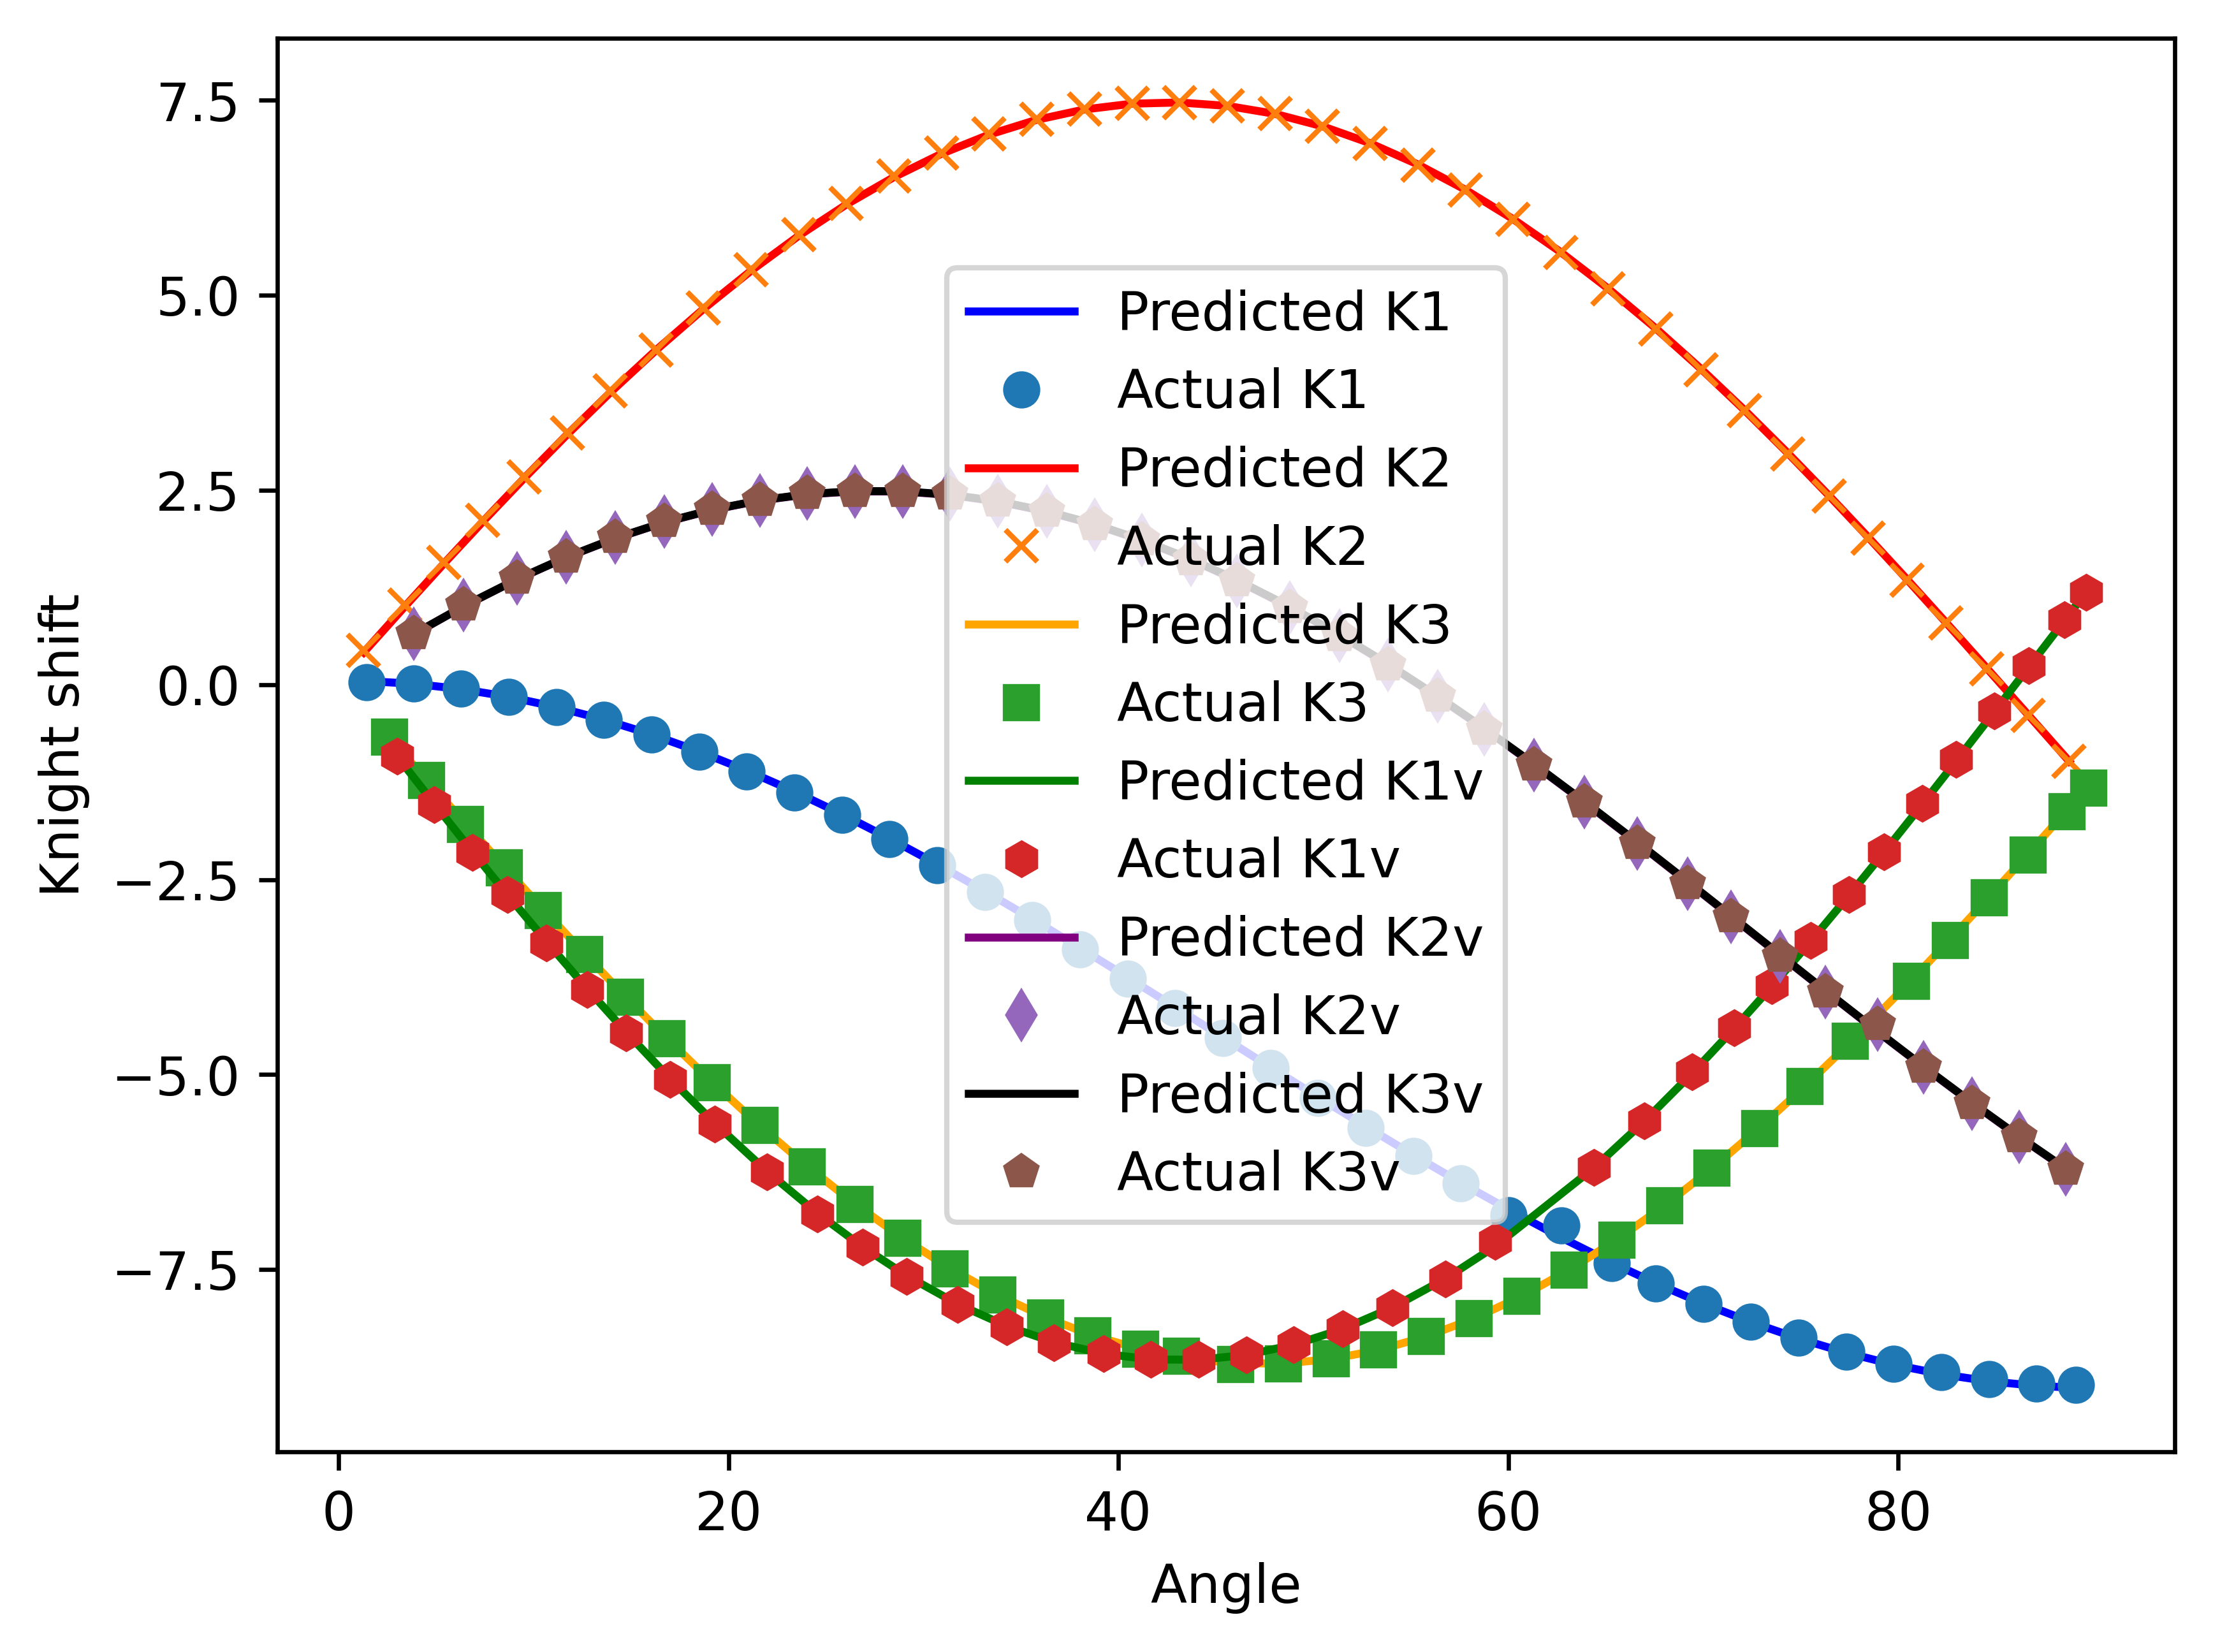

[tensor(-9.0222), tensor(1.3040), tensor(0.0552), tensor(9.3249), tensor(0.), tensor(0.), tensor(89.6840), tensor(89.9883), tensor(0.), tensor(58.6556)]


In [38]:
# 最適化後のパラメータを取得し、Tensorに変換
params = [torch.tensor(val) for val in [k1.item(), k2.item(), k3.item(), k4.item(), k5.item(), k6.item(), t1.item(), p1.item(), t2.item(), p2.item()]]

outputs1 = model(x1, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs2 = model(x2, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs3 = model(x3, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs4 = model(x4, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs5 = model(x5, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)
outputs6 = model(x6, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2)

y_p1 = outputs1['shift1'][0]
y_p2 = outputs2['shift1'][1]
y_p3 = outputs3['shift1'][2]
y_p4 = outputs4['shift2'][0]
y_p5 = outputs5['shift2'][1]
y_p6 = outputs6['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'x', label="Actual K2")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 's', label="Actual K3")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'h', label="Actual K1v")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'd', label="Actual K2v")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'p', label="Actual K3v")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()
print(params)